# Prime Time for Julia and Python

In [88]:
# Packages
using BenchmarkTools
using PyCall
using Plots

## Primes

In [89]:
# Setup
n = 10^6 # number of primes
benchmarks_primes = Dict();

In [90]:
# Python
py"""
def python_primes(n):
    D = {}
    q = 2
    r = []
    counter = 0
    
    while counter < n:
        if q not in D:
            r.append(q)
            D[q * q] = [q]
            counter += 1
        else:
            for p in D[q]:
                D.setdefault(p + q, []).append(p)
            del D[q]
        
        q += 1
    return r
"""

In [91]:
# PyObject
pyPrimes = py"python_primes"


PyObject <function python_primes at 0x1226611f0>

In [92]:
# Demo
pyPrimes(10)

10-element Vector{Int64}:
  2
  3
  5
  7
 11
 13
 17
 19
 23
 29

In [93]:
# Benchmarking
benchmark = @benchmark pyPrimes($n)
benchmarks_primes["Python"] = mean(benchmark.times) / 10^6;

In [94]:
# Julia
function jlPrimes(n)
    D = Dict()
    q = 2
    counter = 0
    P = []

    while counter < n
        if !(q in keys(D))
            D[q * q] = [q]
            push!(P, q)
            counter += 1
        else
            for p in D[q]
                get!(D, p + q, [])
                push!(D[p + q], p)
                delete!(D, q)
            end
        end
        q += 1
    end

    return P
end

jlPrimes (generic function with 1 method)

In [95]:
# Demo
jlPrimes(10)


10-element Vector{Any}:
  2
  3
  5
  7
 11
 13
 17
 19
 23
 29

In [96]:
# Benchmarking
benchmark = @benchmark jlPrimes($n)
benchmarks_primes["Julia without Type Declaration"] = mean(benchmark.times) / 10^6;

In [97]:
# Julia with Type Declaration
function jlPrimesTypes(n::Int64)::Vector{Int64}
    D = Dict{Int64, Vector{Int64}}()
    P = Vector{Int64}()
    q = 2
    counter = 0

    while counter < n
        if !(q in keys(D))
            D[q * q] = Int64[q] # Vector{Int64}([q])
            push!(P, q)
            counter += 1
        else
            for p in D[q]
                get!(D, p + q, Int64[]) # Vector{Int64}()
                push!(D[p + q], p)
                delete!(D, q)
            end
        end
        q += 1
    end

    return P
end

jlPrimesTypes (generic function with 1 method)

In [98]:
# Demo
jlPrimesTypes(10)

10-element Vector{Int64}:
  2
  3
  5
  7
 11
 13
 17
 19
 23
 29

In [99]:
# Benchmarking
benchmark = @benchmark jlPrimesTypes($n)
benchmarks_primes["Julia with Type Declaration"] = mean(benchmark.times) / 10^6;

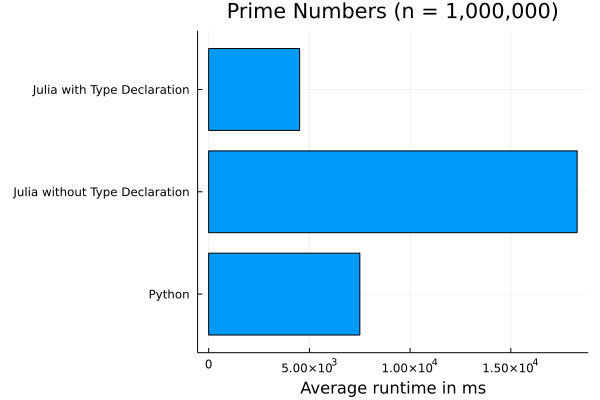

In [100]:
# Plot benchmarks
plot(
    benchmarks_primes, 
    seriestype = :bar, 
    orientation = :horizontal, 
    label = false, 
    xlab = "Average runtime in ms", 
    title = "Prime Numbers (n = 1,000,000)", 
    )
# plot!(size=(900, 600))


In [101]:
# Save plot
png("benchmark_primes.png")

In [102]:
# Compare / validate
pyPrimes(n) == jlPrimes(n) == jlPrimesTypes(n)

true

## Reciprocals

In [103]:
# Prime Number
p = 1212121;

In [104]:
# Test if 1212121 is a prime
p in jlPrimesTypes(p)

true

### Test 1: Using a 'string' for the reciprocals

In [105]:
# Benchmark dictionary
benchmarks_reciprocals_string = Dict();

In [106]:
# Python
py"""
def python_reciprocals(prime: int) -> dict:
    # corner cases
    if prime in [2, 5]:
        raise ValueError('Corner cases are not valid')
    
    # other primes
    start = 10
    reciprocals = ''
    while True: 
        reciprocals += str(start // prime)
        start = (start % prime) * 10
        if start == 10:
            break
    return {'length': len(reciprocals), 'reciprocals': reciprocals}
"""


In [107]:
# PyObject
pyReciprocals = py"python_reciprocals"

PyObject <function python_reciprocals at 0x122661dc0>

In [108]:
# Demo
pyReciprocals(13)

Dict{Any, Any} with 2 entries:
  "length"      => 6
  "reciprocals" => "076923"

In [109]:
# Benchmarking
benchmark = @benchmark pyReciprocals($p)
benchmarks_reciprocals_string["Python"] = mean(benchmark.times) / 10^6;

In [110]:
function jlReciprocals(prime)
	# corner cases
	if prime in [2, 5]
		throw(DomainError(prime, "Corner cases are not valid"))
	end

	# valid primes
	start = 10
	group = ""
	while true
		group *= string(start ÷ prime)
		start = (start % prime) * 10
		if start == 10
			break
		end
	end
	return (lenght=length(group), group=group)
end

jlReciprocals (generic function with 1 method)

In [111]:
# Demo
jlReciprocals(13)

(lenght = 6, group = "076923")

In [112]:
# Benchmarking
benchmark = @benchmark jlReciprocals($p)
benchmarks_reciprocals_string["Julia"] = mean(benchmark.times) / 10^6;

In [113]:
function jlReciprocalsTypes(prime::Int64)::NamedTuple
	# corner cases
	if prime in [2, 5]
		throw(DomainError(prime, "Corner cases are not valid"))
	end

	# valid primes
	start = 10
	group = ""
	while true
		group *= string(start ÷ prime)
		start = (start % prime) * 10
		if start == 10
			break
		end
	end
	return (lenght=length(group), group=group)
end

jlReciprocalsTypes (generic function with 1 method)

In [114]:
# Demo
jlReciprocalsTypes(13)

(lenght = 6, group = "076923")

In [115]:
# Benchmarking
benchmark = @benchmark jlReciprocalsTypes($p)
benchmarks_reciprocals_string["Julia with Type Declarations"] = mean(benchmark.times) / 10^6;

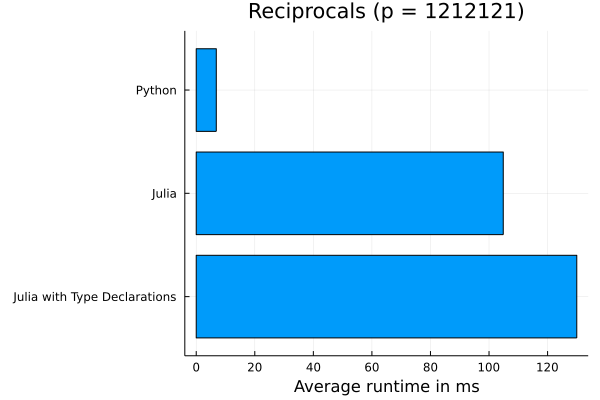

In [116]:
plot(
    benchmarks_reciprocals_string, 
    seriestype = :bar, 
    orientation = :horizontal, 
    label = false, 
    xlab = "Average runtime in ms", 
    title = "Reciprocals (p = 1212121)"
    )
# plot!(size=(900, 600))

In [117]:
# Save plot
png("benchmark_reciprocals_string.png")

### Test 2: Using a 'list' (Python) or 'vector' (Julia) for the reciprocals

In [118]:
# Benchmark dictionary
benchmarks_reciprocals_list = Dict();

In [119]:
# Python
py"""
def python_reciprocals_list(prime: int) -> dict:
    # corner cases
    if prime in [2, 5]:
        raise ValueError('Corner cases are not valid')

    # other primes
    start = 10
    reciprocals = []
    while True: 
        reciprocals.append(start // prime)
        start = (start % prime) * 10
        if start == 10:
            break
    return {'length': len(reciprocals), 'reciprocals': reciprocals}
"""

In [120]:
# PyObject
pyReciprocalsList = py"python_reciprocals_list"

PyObject <function python_reciprocals_list at 0x122661f70>

In [121]:
# Demo
pyReciprocalsList(13)

Dict{Any, Any} with 2 entries:
  "length"      => 6
  "reciprocals" => [0, 7, 6, 9, 2, 3]

In [122]:
# Benchmarking
benchmark = @benchmark pyReciprocalsList($p)
benchmarks_reciprocals_list["Python"] = mean(benchmark.times) / 10^6

16.949934057627118

In [123]:
function jlReciprocalsVector(prime)
	# corner cases
	if prime in [2, 5]
		throw(DomainError(prime, "Corner cases are not valid"))
	end

	start = 10
	group = Vector{Int64}()
	while true
		push!(group, start ÷ prime)
		start = (start % prime) * 10
		if start == 10
			break
		end
	end
	return (lenght=length(group), group=group)
end

jlReciprocalsVector (generic function with 1 method)

In [124]:

# Demo
jlReciprocalsVector(13)

(lenght = 6, group = [0, 7, 6, 9, 2, 3])

In [125]:
# Benchmarking
benchmark = @benchmark jlReciprocalsVector($p)
benchmarks_reciprocals_list["Julia without Type Declarations"] = mean(benchmark.times) / 10^6

0.2557736716

In [126]:
function jlReciprocalsVectorTypes(prime::Int64)::NamedTuple
	# corner cases
	if prime in [2, 5]
		throw(DomainError(prime, "Corner cases are not valid"))
	end
		
	start = 10
	group = Vector{Int64}()
	while true
		push!(group, start ÷ prime)
		start = (start % prime) * 10
		if start == 10
			break
		end
	end
	return (lenght=length(group), group=group)
end

jlReciprocalsVectorTypes (generic function with 1 method)

In [127]:
# Demo
jlReciprocalsVectorTypes(13)

(lenght = 6, group = [0, 7, 6, 9, 2, 3])

In [128]:
# Benchmarking
benchmark = @benchmark jlReciprocalsVectorTypes($p)
benchmarks_reciprocals_list["Julia with Type Declarations"] = mean(benchmark.times) / 10^6;

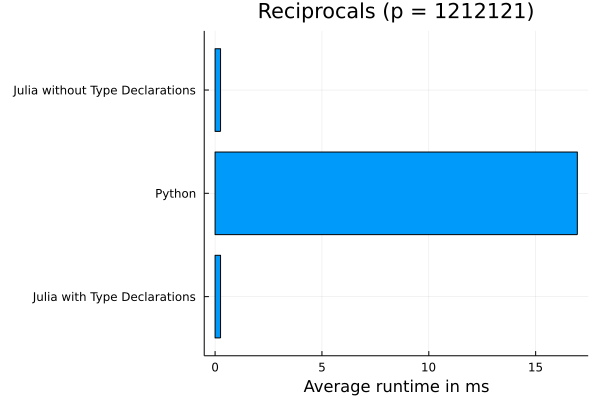

In [129]:
plot(
    benchmarks_reciprocals_list, 
    seriestype = :bar, 
    orientation = :horizontal, 
    label = false, 
    xlab = "Average runtime in ms", 
    title = "Reciprocals (p = 1212121)"
    )
# plot!(size=(900, 600))
    

In [130]:
# Save plot
png("benchmark_reciprocals_list.png")